## Convolution layers pretrained using VGG-16

### Installing Dependencies

### Importing Libraries

In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [46]:
pip install loguru

     |████████████████████████████████| 58 kB 3.0 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt 
import numpy as np
from keras.utils.np_utils import to_categorical
import random,shutil
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.regularizers import l2
from loguru import logger

import cv2
import os
from keras.models import load_model
from pygame import mixer
import time

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Pretrained using VGG-16 (open and close eyes) without Regularization

In [8]:
#Set the batch size
batch_size = 128
#Data Augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  rescale = 1./255, 
                                  zoom_range = 0.2, 
                                  validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
#Generate Train and Test data 
train_data_path_1 = 'dataset_eyes/train'
test_data_path_1 = 'dataset_eyes/test'

train_set = train_datagen.flow_from_directory(train_data_path_1, target_size = (256,256),
                                              batch_size = batch_size, 
                                              #color_mode = 'grayscale',
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_data_path_1, target_size = (256,256),
                                              batch_size = batch_size, 
                                              #color_mode = 'grayscale',
                                              class_mode = 'categorical')

Found 1234 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [10]:
# Initialize the VGG model
vgg1 = VGG16(
    include_top=False, weights='imagenet', input_tensor=None, input_shape= (256,256,3),
)

# Freeze all the layers
for layer in vgg1.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg1.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7facfc1ba640> False
<keras.layers.convolutional.Conv2D object at 0x7facfc1ba040> False
<keras.layers.convolutional.Conv2D object at 0x7facfc1b4040> False
<keras.layers.pooling.MaxPooling2D object at 0x7facfc105490> False
<keras.layers.convolutional.Conv2D object at 0x7facfc105550> False
<keras.layers.convolutional.Conv2D object at 0x7facfc283ac0> False
<keras.layers.pooling.MaxPooling2D object at 0x7facfc28c7c0> False
<keras.layers.convolutional.Conv2D object at 0x7facfc28c400> False
<keras.layers.convolutional.Conv2D object at 0x7facfc28b370> False
<keras.layers.convolutional.Conv2D object at 0x7facfc317640> False
<keras.layers.pooling.MaxPooling2D object at 0x7facfc31bd60> False
<keras.layers.convolutional.Conv2D object at 0x7facfc31b880> False
<keras.layers.convolutional.Conv2D object at 0x7fad0358d610> False
<keras.layers.convolutional.Conv2D object at 0x7fad03592820> False
<keras.layers.pooling.MaxPooling2D object at 0x7fad0358d9a0>

In [11]:
classes = 2
# Create the model
model_eyenoreg = Sequential()

# Add the vgg convolutional base model
model_eyenoreg.add(vgg1)

# Add new layers
model_eyenoreg.add(Flatten())
model_eyenoreg.add(Dense(64, activation='relu', ))
model_eyenoreg.add(Dropout(0.5))
model_eyenoreg.add(Dense(classes, activation='softmax'))



# Show a summary of the model. Check the number of trainable parameters
model_eyenoreg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 16,812,034
Trainable params: 2,097,346
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
# Configure the model for training
model_eyenoreg.compile(loss = 'categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])

In [13]:
#Save the model
model_eyenoreg_path="detection1.h5"

#Create checkpoint to save a model at some interval so that it can be used for training
checkpoint = ModelCheckpoint(model_eyenoreg_path, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [14]:
#Define the Number of Iteration
num_epochs = 50
training_steps=train_set.n//train_set.batch_size
validation_steps =test_set.n//test_set.batch_size

In [15]:
import time
start = time.time()
# Train the model
history1 = model_eyenoreg.fit(train_set, epochs=num_epochs, steps_per_epoch=training_steps,validation_data=test_set,
                    validation_steps=validation_steps, callbacks = callbacks_list)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.3908 - accuracy: 0.4801 
Epoch 1: val_accuracy improved from -inf to 0.53906, saving model to detection1.h5
9/9 [==============================] - 141s 15s/step - loss: 1.3908 - accuracy: 0.4801 - val_loss: 0.6480 - val_accuracy: 0.5391
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.5018 
Epoch 2: val_accuracy did not improve from 0.53906
9/9 [==============================] - 135s 15s/step - loss: 0.6235 - accuracy: 0.5018 - val_loss: 0.5238 - val_accuracy: 0.4766
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.5741 
Epoch 3: val_accuracy improved from 0.53906 to 0.67188, saving model to detection1.h5
9/9 [==============================] - 148s 17s/step - loss: 0.5602 - accuracy: 0.5741 - val_loss: 0.4855 - val_accuracy: 0.6719
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.7685 
Epoch 4: val_accuracy

Epoch 30/50
9/9 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.8698 
Epoch 30: val_accuracy did not improve from 0.98438
9/9 [==============================] - 140s 16s/step - loss: 0.3859 - accuracy: 0.8698 - val_loss: 0.2986 - val_accuracy: 0.9688
Epoch 31/50
9/9 [==============================] - ETA: 0s - loss: 0.3935 - accuracy: 0.8499 
Epoch 31: val_accuracy did not improve from 0.98438
9/9 [==============================] - 151s 17s/step - loss: 0.3935 - accuracy: 0.8499 - val_loss: 0.3019 - val_accuracy: 0.9609
Epoch 32/50
9/9 [==============================] - ETA: 0s - loss: 0.3861 - accuracy: 0.8599 
Epoch 32: val_accuracy did not improve from 0.98438
9/9 [==============================] - 156s 17s/step - loss: 0.3861 - accuracy: 0.8599 - val_loss: 0.2668 - val_accuracy: 0.9844
Epoch 33/50
9/9 [==============================] - ETA: 0s - loss: 0.3883 - accuracy: 0.8535 
Epoch 33: val_accuracy did not improve from 0.98438
9/9 [========================

In [42]:
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    
 
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


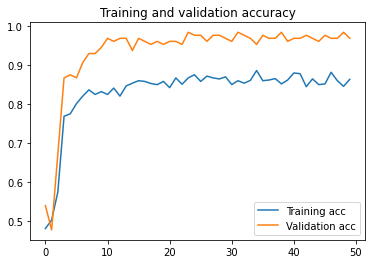

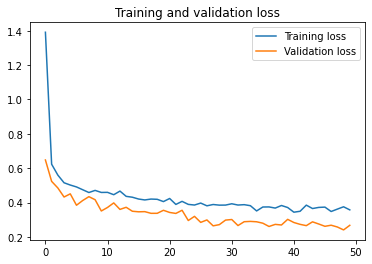

In [43]:
# Run the function to illustrate accuracy and loss
visualize_results(history1)

### Pretrained using VGG-16 (open and close eyes) with Regularization

In [22]:
#Set the batch size
batch_size = 128
#Data Augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  rescale = 1./255, 
                                  zoom_range = 0.2, 
                                  validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
#Generate Train and Test data 
train_data_path_1 = 'dataset_eyes/train'
test_data_path_1 = 'dataset_eyes/test'

train_set = train_datagen.flow_from_directory(train_data_path_1, target_size = (256,256),
                                              batch_size = batch_size, 
                                              #color_mode = 'grayscale',
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_data_path_1, target_size = (256,256),
                                              batch_size = batch_size, 
                                              #color_mode = 'grayscale',
                                              class_mode = 'categorical')

Found 1234 images belonging to 2 classes.
Found 218 images belonging to 2 classes.


In [24]:
# Initialize the VGG model
vgg1 = VGG16(
    include_top=False, weights='imagenet', input_tensor=None, input_shape= (256,256,3),
)

# Freeze all the layers
for layer in vgg1.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg1.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa11a62f790> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a62fc40> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a2cd940> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa11a5873a0> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a90fa60> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a740b80> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa11a592520> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a592160> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a5981c0> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a59b3a0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa11a598d30> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a59b5e0> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a5a9af0> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a5afbb0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa11a5a9220>

In [25]:
classes = 2
# Create the model
model_eyereg = Sequential()

# Add the vgg convolutional base model
model_eyereg.add(vgg1)

# Add new layers
model_eyereg.add(Flatten())
model_eyereg.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_eyereg.add(Dropout(0.5))
model_eyereg.add(Dense(classes, activation='softmax', kernel_regularizer=l2(0.01)))



# Show a summary of the model. Check the number of trainable parameters
model_eyereg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                2097216   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 16,812,034
Trainable params: 2,097,346
Non-trainable params: 14,714,688
_________________________________________________________________


In [30]:
# Configure the model for training
model_eyereg.compile(loss = 'categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])

In [31]:
#Save the model
model_eyereg_path="detection4.h5"
#Create checkpoint to save a model at some interval so that it can be used for training
checkpoint = ModelCheckpoint(model_eyereg_path, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [32]:
#Define the Number of Iteration
num_epochs = 50
training_steps=train_set.n//train_set.batch_size
validation_steps =test_set.n//test_set.batch_size

In [33]:
import time
start = time.time()
history2 = model_eyereg.fit(train_set, epochs=num_epochs, steps_per_epoch=training_steps,validation_data=test_set,
                    validation_steps=validation_steps, callbacks = callbacks_list)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 2.0635 - accuracy: 0.6102 
Epoch 1: val_accuracy improved from -inf to 0.77344, saving model to detection4.h5
9/9 [==============================] - 160s 18s/step - loss: 2.0635 - accuracy: 0.6102 - val_loss: 0.9745 - val_accuracy: 0.7734
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 0.8595 - accuracy: 0.7929 
Epoch 2: val_accuracy improved from 0.77344 to 0.89844, saving model to detection4.h5
9/9 [==============================] - 162s 18s/step - loss: 0.8595 - accuracy: 0.7929 - val_loss: 0.6502 - val_accuracy: 0.8984
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.6417 - accuracy: 0.8951 
Epoch 3: val_accuracy improved from 0.89844 to 0.93750, saving model to detection4.h5
9/9 [==============================] - 166s 18s/step - loss: 0.6417 - accuracy: 0.8951 - val_loss: 0.5438 - val_accuracy: 0.9375
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.5300 - accu

9/9 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9575 
Epoch 30: val_accuracy did not improve from 0.99219
9/9 [==============================] - 151s 17s/step - loss: 0.2186 - accuracy: 0.9575 - val_loss: 0.1738 - val_accuracy: 0.9609
Epoch 31/50
9/9 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9521  
Epoch 31: val_accuracy did not improve from 0.99219
9/9 [==============================] - 1998s 247s/step - loss: 0.2148 - accuracy: 0.9521 - val_loss: 0.2186 - val_accuracy: 0.9531
Epoch 32/50
9/9 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9453 
Epoch 32: val_accuracy did not improve from 0.99219
9/9 [==============================] - 128s 14s/step - loss: 0.2325 - accuracy: 0.9453 - val_loss: 0.1629 - val_accuracy: 0.9922
Epoch 33/50
9/9 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9430 
Epoch 33: val_accuracy did not improve from 0.99219
9/9 [==============================] -

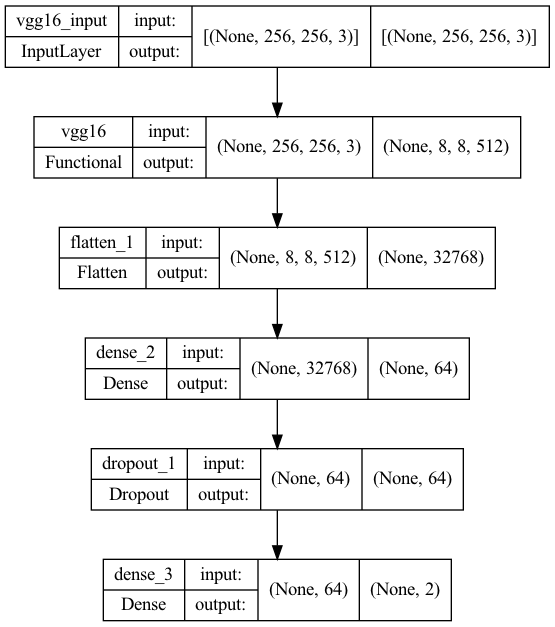

In [44]:
#plot the model architecture
plot_model(model_eyereg, show_shapes=True, to_file='vgg_block.png')

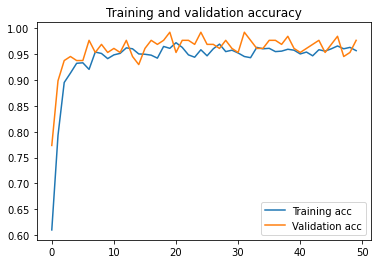

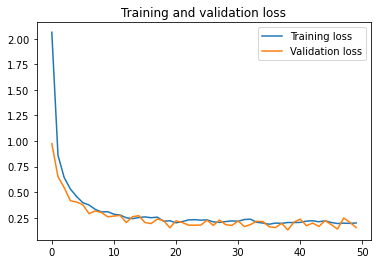

In [45]:

visualize_results(history2)

### Pretrained using VGG-16 (Yawn and No Yawn) without Regularization

In [46]:
#Set the batch size
batch_size = 128
#Data Augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                  rescale = 1./255, 
                                  zoom_range = 0.2, 
                                  validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [47]:
train_data_path_2 = 'dataset_yawn/train'
test_data_path_2 = 'dataset_yawn/test'

train_set = train_datagen.flow_from_directory(train_data_path_2, target_size = (256,256),
                                              batch_size = batch_size, 
                                              #color_mode = 'grayscale',
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_data_path_2, target_size = (256,256),
                                              batch_size = batch_size, 
                                              #color_mode = 'grayscale',
                                              class_mode = 'categorical')

Found 1233 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


In [48]:
# Initialize the VGG model
vgg2 = VGG16(
    include_top=False, weights='imagenet', input_tensor=None, input_shape= (256,256,3),
)

# Freeze all the layers
for layer in vgg2.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa11a52e8b0> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a2a4b80> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a3e1370> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa11cad5bb0> False
<keras.layers.convolutional.Conv2D object at 0x7fa11cad5fa0> False
<keras.layers.convolutional.Conv2D object at 0x7fa11cadb430> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa11a16b640> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a16b340> False
<keras.layers.convolutional.Conv2D object at 0x7facfc005580> False
<keras.layers.convolutional.Conv2D object at 0x7fad03624130> False
<keras.layers.pooling.MaxPooling2D object at 0x7facfc010f40> False
<keras.layers.convolutional.Conv2D object at 0x7fa11cae2130> False
<keras.layers.convolutional.Conv2D object at 0x7facfc0425b0> False
<keras.layers.convolutional.Conv2D object at 0x7fa11a913700> False
<keras.layers.pooling.MaxPooling2D object at 0x7fa11a8ed1c0>

In [49]:
classes = 2
# Create the model
model_yawnnoreg = Sequential()

# Add the vgg convolutional base model
model_yawnnoreg.add(vgg2)
# for layer in vgg.layers[1:]:
#     model.add(layer)


# Add new layers
model_yawnnoreg.add(Flatten())
model_yawnnoreg.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_yawnnoreg.add(Dropout(0.5))
model_yawnnoreg.add(Dense(classes, activation='softmax', kernel_regularizer=l2(0.01)))



# Show a summary of the model. Check the number of trainable parameters
model_yawnnoreg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                2097216   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 16,812,034
Trainable params: 2,097,346
Non-trainable params: 14,714,688
_________________________________________________________________


In [50]:
# Configure the model for training
model_yawnnoreg.compile(loss = 'categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])

In [51]:
#Save the model
model_yawnnoreg_path="detection3.h5"

#Create checkpoint to save a model at some interval so that it can be used for training
checkpoint = ModelCheckpoint(model_yawnnoreg_path, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [52]:
#Define the Number of Iteration
num_epochs = 50
training_steps=train_set.n//train_set.batch_size
validation_steps =test_set.n//test_set.batch_size

In [53]:
import time
start = time.time()
history3 = model_yawnnoreg.fit(train_set, epochs=num_epochs, steps_per_epoch=training_steps,validation_data=test_set,
                    validation_steps=validation_steps, callbacks = callbacks_list)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 3.5632 - accuracy: 0.5131 
Epoch 1: val_accuracy improved from -inf to 0.66406, saving model to detection3.h5
9/9 [==============================] - 141s 16s/step - loss: 3.5632 - accuracy: 0.5131 - val_loss: 1.3202 - val_accuracy: 0.6641
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.5090 - accuracy: 0.6267 
Epoch 2: val_accuracy did not improve from 0.66406
9/9 [==============================] - 170s 19s/step - loss: 1.5090 - accuracy: 0.6267 - val_loss: 1.2003 - val_accuracy: 0.6641
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.1852 - accuracy: 0.6235 
Epoch 3: val_accuracy did not improve from 0.66406
9/9 [==============================] - 173s 19s/step - loss: 1.1852 - accuracy: 0.6235 - val_loss: 1.0937 - val_accuracy: 0.6406
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 1.0888 - accuracy: 0.6570 
Epoch 4: val_accuracy improved from 0.66406 to 0.68750, 

Epoch 30/50
9/9 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.8380 
Epoch 30: val_accuracy did not improve from 0.93750
9/9 [==============================] - 135s 15s/step - loss: 0.5064 - accuracy: 0.8380 - val_loss: 0.4321 - val_accuracy: 0.9062
Epoch 31/50
9/9 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.8462 
Epoch 31: val_accuracy did not improve from 0.93750
9/9 [==============================] - 145s 16s/step - loss: 0.4900 - accuracy: 0.8462 - val_loss: 0.4317 - val_accuracy: 0.8984
Epoch 32/50
9/9 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.8109 
Epoch 32: val_accuracy did not improve from 0.93750
9/9 [==============================] - 135s 16s/step - loss: 0.5381 - accuracy: 0.8109 - val_loss: 0.4982 - val_accuracy: 0.8984
Epoch 33/50
9/9 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.8199 
Epoch 33: val_accuracy did not improve from 0.93750
9/9 [========================

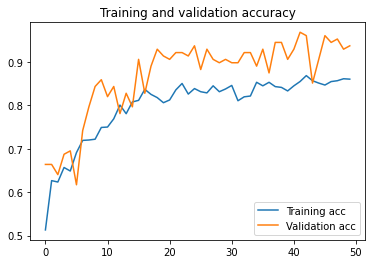

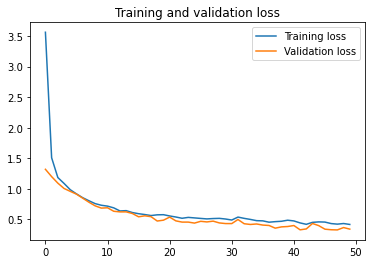

In [54]:
#Visualize the results
visualize_results(history3)

 ### Pretrained using VGG-16 (Yawn and No Yawn) with Regularization

In [55]:
classes = 2
# Create the model
model_yawnreg = Sequential()

# Add the vgg convolutional base model
model_yawnreg.add(vgg2)
# for layer in vgg.layers[1:]:
#     model.add(layer)


# Add new layers
model_yawnreg.add(Flatten())
model_yawnreg.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_yawnreg.add(Dropout(0.5))
model_yawnreg.add(Dense(classes, activation='softmax', kernel_regularizer=l2(0.01)))



# Show a summary of the model. Check the number of trainable parameters
model_yawnreg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 64)                2097216   
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 16,812,034
Trainable params: 2,097,346
Non-trainable params: 14,714,688
_________________________________________________________________


In [56]:
# Configure the model for training
model_yawnreg.compile(loss = 'categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])

In [61]:
#Save the model
model_yawnreg_path="detection4.h5"

#Create checkpoint to save a model at some interval so that it can be used for training
checkpoint = ModelCheckpoint(model_yawnreg_path, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, mode='max')

callbacks_list = [checkpoint]

In [62]:
#Define the Number of Iteration
num_epochs = 50
training_steps=train_set.n//train_set.batch_size
validation_steps =test_set.n//test_set.batch_size

In [63]:
import time
start = time.time()
history_4 = model_yawnreg.fit(train_set, epochs=num_epochs, steps_per_epoch=training_steps,validation_data=test_set,
                    validation_steps=validation_steps, callbacks = callbacks_list)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 2.4664 - accuracy: 0.5475 
Epoch 1: val_accuracy improved from -inf to 0.58594, saving model to detection4.h5
9/9 [==============================] - 124s 13s/step - loss: 2.4664 - accuracy: 0.5475 - val_loss: 1.2603 - val_accuracy: 0.5859
Epoch 2/50
9/9 [==============================] - ETA: 0s - loss: 1.2811 - accuracy: 0.6027 
Epoch 2: val_accuracy improved from 0.58594 to 0.69531, saving model to detection4.h5
9/9 [==============================] - 124s 14s/step - loss: 1.2811 - accuracy: 0.6027 - val_loss: 1.1264 - val_accuracy: 0.6953
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.1080 - accuracy: 0.6226 
Epoch 3: val_accuracy did not improve from 0.69531
9/9 [==============================] - 134s 15s/step - loss: 1.1080 - accuracy: 0.6226 - val_loss: 1.0377 - val_accuracy: 0.6641
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.9982 - accuracy: 0.6534 
Epoch 4: val_accuracy

9/9 [==============================] - ETA: 0s - loss: 0.4744 - accuracy: 0.8009 
Epoch 29: val_accuracy improved from 0.96094 to 0.96875, saving model to detection4.h5
9/9 [==============================] - 179s 21s/step - loss: 0.4744 - accuracy: 0.8009 - val_loss: 0.3053 - val_accuracy: 0.9688
Epoch 30/50
9/9 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.7960 
Epoch 30: val_accuracy did not improve from 0.96875
9/9 [==============================] - 196s 22s/step - loss: 0.4906 - accuracy: 0.7960 - val_loss: 0.3055 - val_accuracy: 0.9375
Epoch 31/50
9/9 [==============================] - ETA: 0s - loss: 0.5111 - accuracy: 0.7864 
Epoch 31: val_accuracy did not improve from 0.96875
9/9 [==============================] - 175s 19s/step - loss: 0.5111 - accuracy: 0.7864 - val_loss: 0.3113 - val_accuracy: 0.9297
Epoch 32/50
9/9 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.8118 
Epoch 32: val_accuracy did not improve from 0.96875
9/9 [=

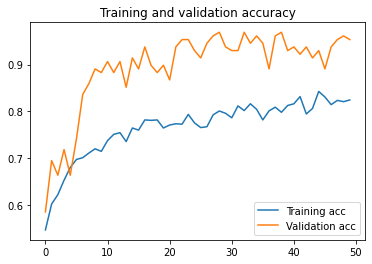

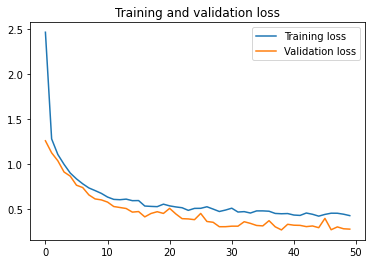

In [64]:
#Visualize the results
visualize_results(history_4)